# Wine Classification

*Предсказать сорт винограда из которого сделано вино, используя [результаты химических анализов](https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data) ([описание данных](http://archive.ics.uci.edu/ml/datasets/Wine)), c помощью KNN - метода k ближайших соседей с тремя различными метриками. Построить график зависимости величины ошибки от числа соседей k.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from ipywidgets import interact
from matplotlib.colors import ListedColormap

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Прочитаем данные из файла и запишем в полученный DataFrame названия признаков
data = pd.read_csv('wine.csv', header=None)

In [3]:
#Запишем названия признаков
data.columns = ["Sort", "Alcohol", "Malic acid", "Ash", "Alcalinity of ash ", 
                "Magnesium", "Total phenols", "Flavanoids", 
                "Nonflavanoid phenols", "Proanthocyanins", "Color intensity",
                "Hue", "OD280/OD315", "Proline"]

features = ["Alcohol", "Malic acid", "Ash", "Alcalinity of ash ", 
                "Magnesium", "Total phenols", "Flavanoids", 
                "Nonflavanoid phenols", "Proanthocyanins", "Color intensity",
                "Hue", "OD280/OD315", "Proline"]

data.head()

,Sort,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
#Проверка на "пробелы" в данных
pd.isnull(data).sum()

Sort                    0
Alcohol                 0
Malic acid              0
Ash                     0
Alcalinity of ash       0
Magnesium               0
Total phenols           0
Flavanoids              0
Nonflavanoid phenols    0
Proanthocyanins         0
Color intensity         0
Hue                     0
OD280/OD315             0
Proline                 0
dtype: int64

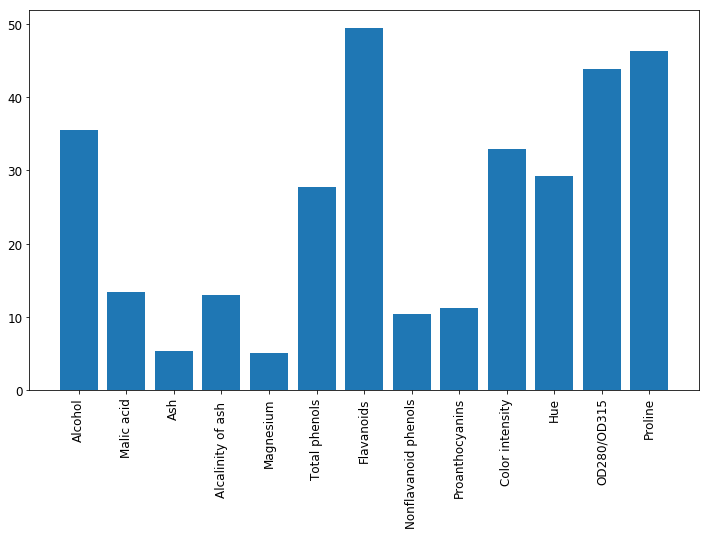

In [5]:
#Найдем наиболее важные признаки
selector = SelectKBest(f_classif, k='all')
selector.fit(data.drop(['Sort'], axis=1), data['Sort'].ravel())

#самый большой результат соответствует самому малому значению
#p-значения(вероятность ошибки)
scores = -np.log10(selector.pvalues_)

plt.figure(figsize=(12, 7))
plt.bar(range(len(features)), scores)
plt.xticks(range(len(features)), features, rotation='vertical')
plt.show()

Из полученной гистограммы видно, что наиболее важными признаками являются
$\textit{Alcohol}$, $\textit{Flavanoids}$, $\textit{OD280/OD315}$, $\textit{Proline}$.

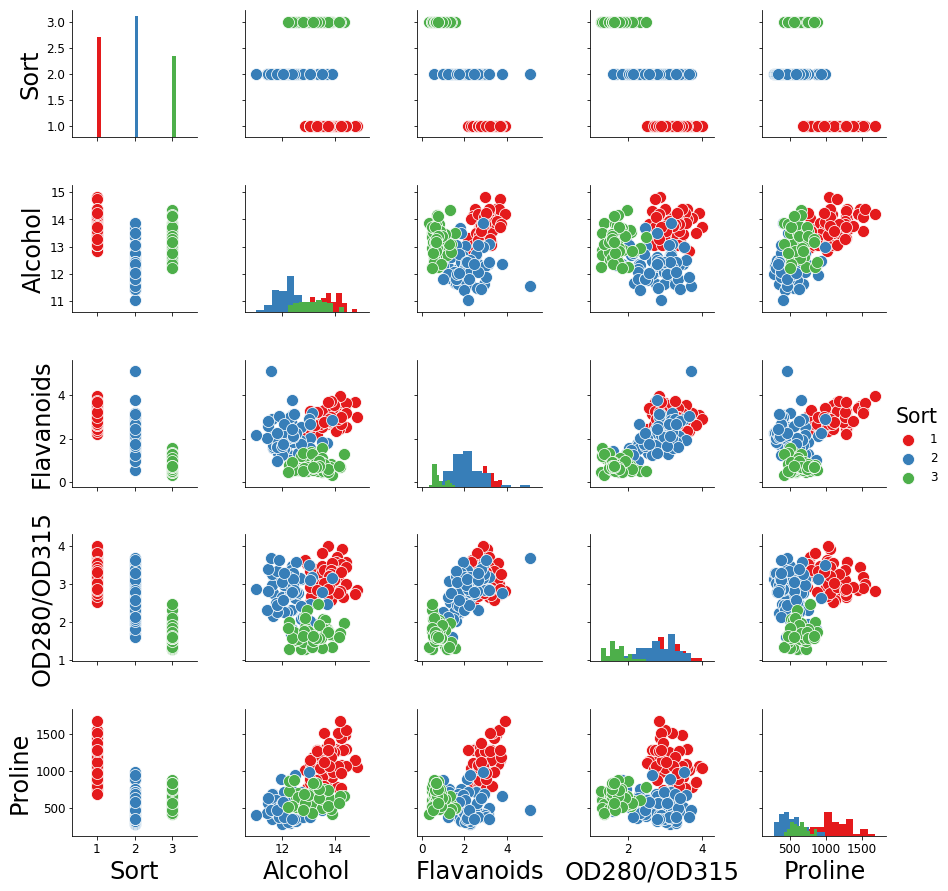

In [6]:
#Рассмотрим, как связаны между собой эти признаки
#и выберем наиболее удобные для выделения сортов винограда
data1 = data[['Sort','Alcohol','Flavanoids','OD280/OD315','Proline']]
sns_plot = sns.pairplot(data1, hue='Sort', palette="Set1", diag_kind="hist")

Видно, что взять стоит признаки $\textit{Alcohol}$ и $\textit{Flavanoids}$, т.к. у них наиболее четко видно разделения классов. Для остальных же признаков из графиков видно, что имеет место достаточно сильное перекрывание классов, из-за чего будет трудно предсказать, к какому сорту винограда принадлежит вино.

In [7]:
#Разделим наш датасет на тестовую и контрольную выборки
X_train, X_test, y_train, y_test = train_test_split(
    data[['Alcohol', 'Flavanoids']], data['Sort'], test_size=0.3, stratify=data['Sort'], random_state=42)

In [8]:
#Проведем нормализацию признаков, т.к. алгоритм kNN чувствителен к масштабированию данных
scaler = preprocessing.StandardScaler().fit(X_train)
X_test = scaler.transform(X_test)
X_train = scaler.transform(X_train)

In [9]:
#Посчитаем точность предсказания сорта
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)
print ("Accuracy on test: {:.2f}%".format(clf.score(X_test, y_test)*100))

Accuracy on test: 90.74%


### Рассмотрим метрики Евклида, Манхэттена и Чебышева.

In [10]:
X = data[['Alcohol','Flavanoids']]
y = data['Sort']
neighbors = np.arange(1, 80)
metrics_errors = {'euclidean':[], 'manhattan':[], 'chebyshev':[]}
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
cross_val_scr = np.empty(len(neighbors))

for metric in ['euclidean','manhattan','chebyshev']:
    for i, k in enumerate(neighbors):
        clf = KNeighborsClassifier(n_neighbors=k, metric = metric)
        scores = cross_val_score(clf, X, y, scoring='accuracy', cv=StratifiedKFold(shuffle = False, n_splits=5))
        cross_val_scr[i] = scores.mean()
        metrics_errors[metric].append(1 - cross_val_scr[i])
    min_error = min(metrics_errors[metric])
    min_neighbor = metrics_errors[metric].index(min_error)
    print("Optimal error for {} metric: {:.2f}% with {} neighbors.".format(
        metric.capitalize(), (1 - np.amax(cross_val_scr))*100, np.argmax(cross_val_scr)))

Optimal error for Euclidean metric: 4.93% with 15 neighbors.
Optimal error for Manhattan metric: 4.93% with 17 neighbors.
Optimal error for Chebyshev metric: 5.55% with 10 neighbors.


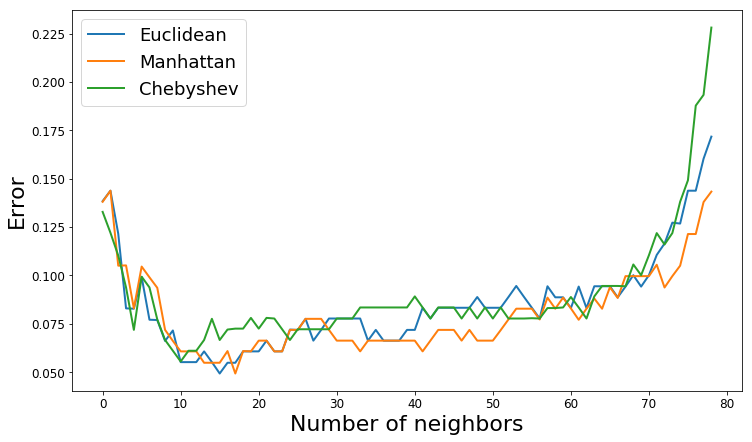

In [11]:
#Построим график зависимости ошибки от числа соседей k при разных метриках
plt.figure(figsize=(12,7))
plt.xlabel('Number of neighbors', fontsize=22)
plt.ylabel('Error', fontsize=22)

for metric in metrics_errors.keys():
    plt.plot(metrics_errors[metric], label=metric.capitalize())
    
plt.legend(fontsize=18)    
plt.savefig(fname='Metrics_hw2.png',format='png')

### Также можно рассмотреть метрику Минковского.

Построим интерактивный виджет, с помощью которого можно будет рассмотреть границы между сортами винограда при различных степенях $p$.

In [12]:
X = data[['Alcohol','Flavanoids']].values
y = data[['Sort']].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)

h = 0.01

#Создаем color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

#Напишем функцию, которая будет строить график для метрики Минковского   
def plot_mink(n_neighbors, metric, p):
        clf = KNeighborsClassifier(algorithm='kd_tree',
                                   n_neighbors=n_neighbors, 
                                   metric=metric, 
                                   weights='uniform',
                                   p=p).fit(X_train, y_train.ravel())

        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
        acc = accuracy_score(y_test, clf.predict(X_test))
        
        Z = Z.reshape(xx.shape)
        plt.figure()
        plt.figure(figsize=(12, 8))
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
        plt.xlabel('Alcohol')
        plt.ylabel('Flavanoids')

        plt.scatter(X[:, 0], X[:, 1], cmap=cmap_bold,
                    edgecolor='k', s=20, c=y.ravel())
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title("k = {}, accuracy = {:.2f}".format(n_neighbors, acc))

In [13]:
_ = interact(plot_mink, 
             n_neighbors = (1, 20), 
             metric = ['minkowski'],
             p = (1,5))

interactive(children=(IntSlider(value=10, description='n_neighbors', max=20, min=1), Dropdown(description='met…